In [1]:
import mhkit
from mhkit.wave import resource
from mhkit.wave.io import ndbc
import matplotlib.pyplot as plt
from matplotlib import colors 
import pandas as pd
import numpy as np
import calendar

In [4]:
parameter = 'swden'
buoy_number = '46050' 
ndbc_available_data= ndbc.available_data(parameter, buoy_number)
years_of_interest = ndbc_available_data[ndbc_available_data.year < 2013]
filenames= years_of_interest['filename']
ndbc_requested_data = ndbc.request_data(parameter, filenames)

,id,year,filename
1688,46050,1996,46050w1996.txt.gz
1689,46050,1997,46050w1997.txt.gz
1690,46050,1998,46050w1998.txt.gz
1691,46050,1999,46050w1999.txt.gz
1692,46050,2000,46050w2000.txt.gz
1693,46050,2001,46050w2001.txt.gz
1694,46050,2002,46050w2002.txt.gz
1695,46050,2003,46050w2003.txt.gz
1696,46050,2004,46050w2004.txt.gz
1697,46050,2005,46050w2005.txt.gz


In [5]:
ndbc_data={}
# Create a Datetime Index and remove NOAA date columns for each year
for year in ndbc_requested_data:
    year_data = ndbc_requested_data[year]
    ndbc_data[year] = ndbc.to_datetime_index(parameter, year_data)

In [6]:
res = resource.energy_flux(ndbc_data['1996'].T,h=399.)

In [7]:
# Intialize empty lists to store the results from each year
Hm0_list=[]
Te_list=[]
J_list=[]

# Iterate over each year and save the result in the initalized dictionary
for year in ndbc_data:
    year_data = ndbc_data[year]
    Hm0_list.append(resource.significant_wave_height(year_data.T))
    Te_list.append( resource.energy_period(year_data.T))
    J_list.append(  resource.energy_flux(year_data.T, h=399.))

# Concatenate list of Series into a single DataFrame
Te = pd.concat(Te_list ,axis=0)
Hm0 = pd.concat(Hm0_list ,axis=0)
J = pd.concat(J_list ,axis=0)
data = pd.concat([Hm0, Te, J],axis=1)

# Drop any NaNs created from the calculation of Hm0 or Te
data.dropna(inplace=True)
# Sort the DateTime index
data.sort_index(inplace=True)
data

C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Hm0,Te,J
date,,,
1996-01-01 00:00:00,77.935358,7.311955,2.230499e+07
1996-01-01 01:00:00,5.215669,13.120481,1.752212e+05
1996-01-01 02:00:00,4.582576,12.233122,1.260913e+05
1996-01-01 03:00:00,4.968219,12.652905,1.532625e+05
1996-01-01 04:00:00,4.432245,12.294969,1.185388e+05
...,...,...,...
2012-12-31 19:00:00,2.955808,14.530107,6.228156e+04
2012-12-31 20:00:00,2.626937,13.967092,4.727815e+04
2012-12-31 21:00:00,2.826730,13.612849,5.334528e+04


## Annual Scatter Table

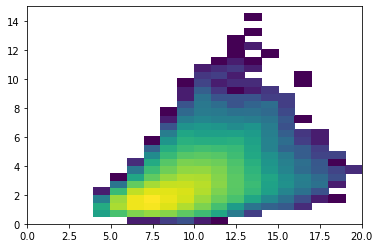

In [8]:
# Remove Hm0 Outliers
data_clean = data[data.Hm0 < 20]
sigma = data_clean.J.std()
data_clean = data_clean[data_clean.J > (data_clean.J.mean() - 0.9* sigma)]
#data_clean = data_clean[data_clean.J < data_clean.J.mean() + 3* data_clean.J.std()]

Hm0_bin_size = 0.5
Hm0_edges = np.arange(0,15+Hm0_bin_size,Hm0_bin_size)


Te_bin_size = 1
Te_edges = np.arange(0, 20+Te_bin_size,Te_bin_size)
Te_edges

h= plt.hist2d(data_clean.Te,  
           data_clean.Hm0, 
           bins = (Te_edges,Hm0_edges), 
           norm = colors.LogNorm())

In [9]:
data.describe()

,Hm0,Te,J
count,127994.000000,127994.000000,1.279940e+05
mean,3.227731,8.936628,2.717057e+05
std,7.794570,2.037081,2.260086e+06
min,0.120000,4.037509,4.251706e+01
25%,1.536229,7.362985,8.829633e+03
50%,2.134666,8.709283,1.905313e+04
75%,3.053326,10.199964,4.555719e+04
max,77.935358,20.743978,2.230499e+07


## Wave Power by Month

In [39]:
data_clean.groupby(months).describe()['Hm0',   '25%']

date
1     2.266252
2     2.161967
3     2.129883
4     1.720930
5     1.371277
6     1.247998
7     1.230285
8     1.126499
9     1.370547
10    1.793878
11    2.210520
12    2.277147
Name: (Hm0, 25%), dtype: float64

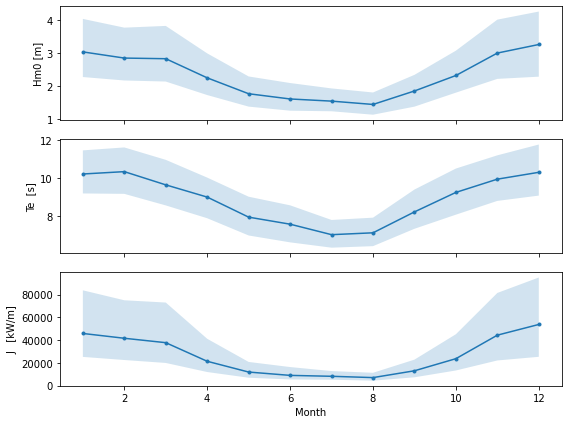

In [50]:
months=data_clean.index.month
data_group=data_clean.groupby(months)
# 3 plots
fig, axs = plt.subplots(3,1, figsize=(8, 6), sharex=True)
#shade between 25% and 75%
QoIs = data_clean.keys()
for i in range(len(QoIs)):
    QoI = QoIs[i]
    axs[i].plot(data_group.median()[QoI], marker='.')

    axs[i].fill_between(months.unique(),
                        data_group.describe()[QoI,   '25%'],
                        data_group.describe()[QoI,   '75%'],
                        alpha=0.2)

plt.setp(axs[2], xlabel='Month')
plt.setp(axs[0], ylabel='Hm0 [m]')

plt.setp(axs[1], ylabel='Te  [s]')
plt.setp(axs[2], ylabel='J   [kW/m]')

plt.tight_layout()

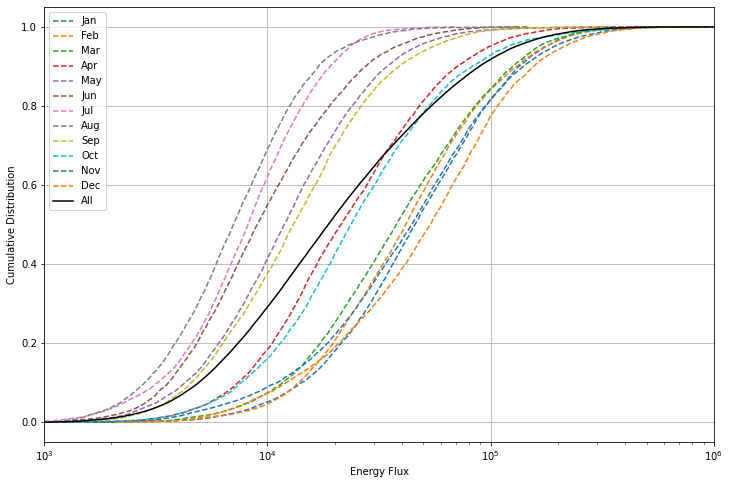

In [29]:
cumSum={}
for month in data_clean.index.month.unique():
    
    F = mhkit.river.resource.exceedance_probability(data_clean[data_clean.index.month==month].J)
    cumSum[month] = 1-F/100
    cumSum[month].sort_values('F', inplace=True)
plt.figure(figsize=(12,8) )
for month in data_clean.index.month.unique():
    plt.semilogx(data_clean.loc[cumSum[month].index].J, cumSum[month].F, '--', label=calendar.month_abbr[month])

F = mhkit.river.resource.exceedance_probability(data_clean.J)
F.sort_values('F', inplace=True)
plt.semilogx(data_clean.loc[F.index].J, 1-F/100, 'k-', fillstyle='none', label='All')

plt.xlim([1000, 1E6])    
plt.grid()
plt.xlabel('Energy Flux')
plt.ylabel('Cumulative Distribution')
plt.legend()